# Problemas

Como semana passada, nesta prática iremos usar tudo que aprendemos durante a semana.
Logo, **seu objetivo é determinar e implementar um modelo para cada problema.**

Lembre-se de definir:

1. uma arquitetura (tentem usar tanto arquiteturas existentes como propor novas usando camadas de convolução, pooling, e densas), 
1. uma função de custo, e
1. um algoritmo de otimização (agora, como os problemas são maiores, será possível notar mais claramente a diferença entre diferentes algoritmos).





Antes de começar, vamos instalar o Pytorch. Esse pequeno bloco de código abaixo é usado somente para instalar o Pytorch para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [0]:
!pip3 install torch torchvision

In [0]:
import time, os, sys, numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch import optim
from torchsummary import summary


import time, os, sys, numpy as np

# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids= list(range(n))

In [0]:
# funções básicas
def _get_batch(batch):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.type() != features.type():
        labels = labels.type(features.type())
    return (torch.nn.DataParallel(features, device_ids=devices_ids),
            torch.nn.DataParallel(labels, device_ids=devices_ids), features.shape[0])

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss,
                   num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            trainer.zero_grad()
            l = loss(y_hat, y).sum()
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

## Problema 1

No primeiro problema, classificaremos imagens de sensoriamento remoto de plantações de café do dataset público [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/).
Neste caso, , vamos receber imagens de $64\times 64$ pixels e classificá-las entre duas classes: 

1. café, e 
2. não café.

In [0]:
!wget http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
!unzip -q brazilian_coffee_dataset.zip

class CoffeeDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for i in range(1,5):
            data_file = open(os.path.join(root, 'fold' + str(i+1) + '.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold' + str(i+1), img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
        else:
            data_file = open(os.path.join(root, 'fold1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold1', img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(torchvision.transforms.functional.to_tensor(Image.open(self.img_list[item])).astype('float32'))
        else:
            cur_img = torchvision.functional.to_tensor(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = torchvision.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [torchvision.transforms.Resize(resize)]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=227)

--2019-10-16 21:20:21--  http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
Resolving www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)... 150.164.0.131
Connecting to www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)|150.164.0.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796290 (4.6M) [application/zip]
Saving to: ‘brazilian_coffee_dataset.zip.2’

brazilian_coffee_da 100%[===================>]   4.57M  1.56MB/s    in 2.9s    

2019-10-16 21:20:24 (1.56 MB/s) - ‘brazilian_coffee_dataset.zip.2’ saved [4796290/4796290]

replace brazilian_coffee_scenes/fold5.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Problema 2

Neste segundo problema, classificaremos imagens gerais de sensoriamento remoto do dataset público [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels e classificá-las entre 21 classes: 

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [0]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

class UCMercedDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for cat, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
        else:
          for cat, folder in enumerate(os.listdir(os.path.join(self.root))):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(torchvision.transforms.functional.to_tensor(Image.open(self.img_list[item])).astype('float32'))
        else:
            cur_img = torchvision.functional.to_tensor(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = torchvision.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [torchvision.transforms.Resize(resize)]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), batch_size, resize=227)

--2019-10-16 21:26:23--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.1’

UCMerced_LandUse.zi 100%[===================>] 317.07M  36.0MB/s    in 14s     

2019-10-16 21:26:37 (22.7 MB/s) - ‘UCMerced_LandUse.zip.1’ saved [332468434/332468434]

replace UCMerced_LandUse/Images/agricultural/agricultural00.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Problema 3

No terceiro problema, classificaremos imagens genéricas de textura do dataset público [*Describable Textures Dataset*](http://www.robots.ox.ac.uk/~vgg/data/dtd/).
Neste caso, vamos receber imagens com tamanho variado (de $300\times 300$ pixels até $640\times 640$) e classificá-las entre 47 classes: 

1.  banded
1.  blotchy
1.  braided
1.  bubbly
1.  bumpy
1.  chequered
1.  cobwebbed
1.  cracked
1.  crosshatched
1.  crystalline
1.  dotted
1.  fibrous
1.  flecked
1.  freckled
1.  frilly
1.  gauzy
1.  grid
1.  grooved
1.  honeycombed
1.  interlaced
1.  knitted
1.  lacelike
1.  lined
1.  marbled
1.  matted
1.  meshed
1.  paisley
1.  perforated
1.  pitted
1.  pleated
1.  polka-dotted
1.  porous
1.  potholed
1.  scaly
1.  smeared
1.  spiralled
1.  sprinkled
1.  stained
1.  stratified
1.  striped
1.  studded
1.  swirly
1.  veined
1.  waffled
1.  woven
1.  wrinkled
1.  zigzagged

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xzf dtd-r1.0.1.tar.gz

class TextureDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'banded': 0, 'blotchy': 1, 'braided': 2, 'bubbly': 3, 'bumpy': 4, 'chequered': 5, 'cobwebbed': 6, 'cracked': 7, 'crosshatched': 8, 'crystalline': 9, 'dotted': 10, 'fibrous': 11, 'flecked': 12, 'freckled': 13, 'frilly': 14, 'gauzy': 15, 'grid': 16, 'grooved': 17, 'honeycombed': 18, 'interlaced': 19, 'knitted': 20, 'lacelike': 21, 'lined': 22, 'marbled': 23, 'matted': 24, 'meshed': 25, 'paisley': 26, 'perforated': 27, 'pitted': 28, 'pleated': 29, 'polka-dotted': 30, 'porous': 31, 'potholed': 32, 'scaly': 33, 'smeared': 34, 'spiralled': 35, 'sprinkled': 36, 'stained': 37, 'stratified': 38, 'striped': 39, 'studded': 40, 'swirly': 41, 'veined': 42, 'waffled': 43, 'woven': 44, 'wrinkled': 45, 'zigzagged': 46}
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
            data_file = open(os.path.join(root, 'labels', 'train1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
                
            data_file = open(os.path.join(root, 'labels', 'val1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
        else:
            data_file = open(os.path.join(root, 'labels', 'test1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])

        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(torchvision.transforms.functional.to_tensor(Image.open(self.img_list[item])).astype('float32'))
        else:
            cur_img = torchvision.functional.to_tensor(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = torchvision.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [torchvision.transforms.Resize(resize)]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=224)

--2019-10-16 21:28:28--  http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  32.4MB/s    in 19s     

2019-10-16 21:28:48 (31.2 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



## Problema 4

Neste último problema, classificaremos imagens histólogica do dataset [*Colorectal Histology*](https://www.kaggle.com/kmader/colorectal-histology-mnist).
Neste caso, vamos receber imagens com tamanho de $150\times 150$ pixels e classificá-las entre 8 classes: 

1. tumor
1. stroma
1. complex
1. lympho
1. debris
1. mucosa
1. adipose
1. empty

In [0]:
!wget https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
!unzip -q Kather_texture_2016_image_tiles_5000.zip

class HistologyDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'tumor': 0, 'stroma': 1, 'complex': 2, 'lympho': 3, 'debris': 4, 'mucosa': 5, 'adipose': 6, 'empty': 7}
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for folder in os.listdir(self.root):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
        else:
          for folder in os.listdir(os.path.join(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(torchvision.transforms.functional.to_tensor(Image.open(self.img_list[item])).astype('float32'))
        else:
            cur_img = torchvision.transforms.functional.to_tensor(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = torchvision.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [torchvision.transforms.Resize(resize)]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=224)

--2019-10-16 21:53:03--  https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip [following]
--2019-10-16 21:53:03--  https://www.dropbox.com/s/raw/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc12b9f8aecc721112b8b804ee2.dl.dropboxusercontent.com/cd/0/inline/Aqme3mhcYm3YlOmY3ZGWWk3kMv9ZzZ0iPCezph78EHEqp1ZZqB0Se5D-G-uD0dWkjMOA4FSXr8oavFgXx7OQRtBR23hp8o3qTeTewYL-7e8hrw/file# [following]
--2019-10-16 21:53:03--  https://ucc12b9f8aecc721112b8b804ee2.dl.dropboxusercontent.com/cd/0/inline/Aqme3mhcYm3YlOmY3ZGWWk3kMv9ZzZ0iPCezph78EHEqp1ZZqB0

In [0]:
from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    axes = plt.subplots(num_rows, num_cols, figsize=figsize)[1].flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8c929b898>,
      dtype=object)

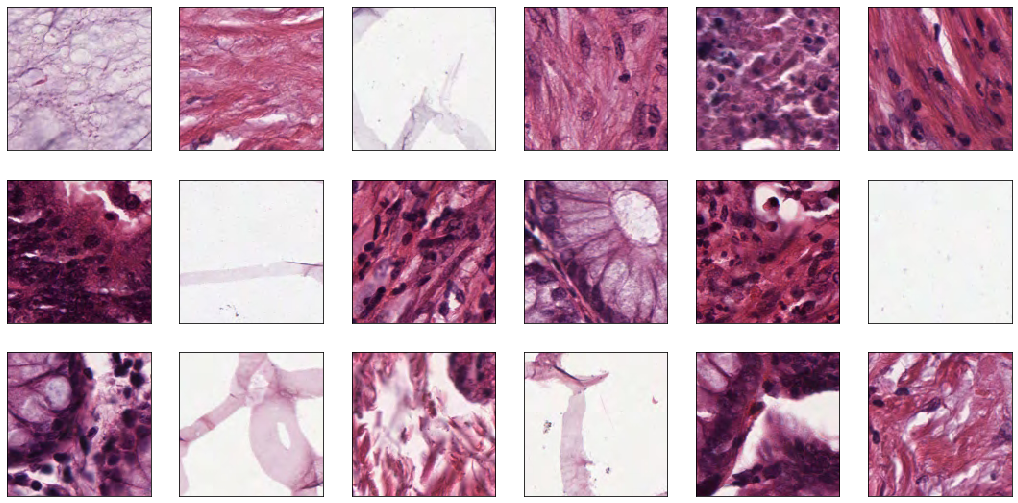

In [0]:
imgs = []
for X, y in train_iter:
    X = np.swapaxes(X, 1, 3)
    imgs = X[0:18]
    break
    
    
show_images(imgs, 3, 6, titles=None, scale=3)